In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit
import random
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

# Boids model
Consider a flock of birds. If they are located in a too dense area, then they want to repell each other. 
At some intermediate distance, for example in a distance where they can see. each other, then birds will get attracted to each other and move in the same direction. In the same time, the flock will also try to cluster to the center of mass. The behvaior can be summarized as:
1. Separation
2. Alignment 
3. Cohesion

In [250]:
np.random.seed(42)

# Simulation parameters
r1, r2, r3 = 1, 5, 10
N = 100  # Number of particles
x1, x2 = -10, 10
v1, v2 = -1, 1
rho1, rho2, rho3, rho4 = [0.1, 0.6, 0.2, 0.1]
eta = 0.5 * np.pi  # random factor upper bound (in radians)

# Animation constants 
time_steps = 10000
factor = 50 
frames = time_steps // factor
dt = 1e2 / time_steps


position_history = np.zeros([frames, N, 2])
xy = np.random.uniform(x1, x2, [N, 2])  # Particle positions
v  = np.random.uniform(v1, v2, [N, 2])  # Particle velocities

# Function for computing distances
@njit
def get_distances(xy):
    N = len(xy)
    separation = np.zeros((N, N, 2))
    for i in range(N):
        for j in range(N):
            separation[i, j] = xy[i] - xy[j]
    pair_wise_distance = np.sqrt(np.sum(separation**2, axis=-1))
    return pair_wise_distance


def theta1(xy):
    center_of_mass = np.mean(xy, axis=0) 
    repulsion_vectors = xy - center_of_mass
    theta = np.arctan2(repulsion_vectors[:, 1], repulsion_vectors[:, 0])
    return theta

@njit
def theta2(xy, v, i, alignment_indices):
    # find indices of neighboring particles within radius r2
    neighbors_indices = alignment_indices[i]
    # get velocities of neighboring particles
    neighbors_v = v[neighbors_indices] 
    # calculate angles of velocities
    neighbors_theta = np.arctan2(neighbors_v[:, 1], neighbors_v[:, 0])
    # calculate mean direction angle using circular mean
    mean_direction = np.arctan2(np.sum(np.sin(neighbors_theta)), np.sum(np.cos(neighbors_theta)))
    return mean_direction



def theta3(xy):
    center_of_mass = np.mean(xy, axis=0) 
    attraction_vectors = center_of_mass - xy
    theta = np.arctan2(attraction_vectors[:, 1], attraction_vectors[:, 0])
    return theta



@njit
def update_angle(repelling_angles, theta2_value, attracting_angles):
    angle = (
            rho1 * np.mean(repelling_angles) if repelling_angles.size > 0 else 0
            + rho2 * theta2_value
            + rho3 * np.mean(attracting_angles) if attracting_angles.size > 0 else 0
            + rho4 * np.random.uniform(-eta, eta)
    )
    return angle



f = 0
for t in tqdm(range(time_steps)):
    if t % factor == 0:
        position_history[f] = xy
        f += 1

    distance = get_distances(xy)

    repelling_indices  = (distance != 0)  * (distance < r1)
    alignment_indices  = (distance >= r1) * (distance < r2)
    attracting_indices = (distance >= r2) * (distance < r3)

    theta1_values = theta1(xy)
    theta3_values = theta3(xy)

    # Update velocities
    for i in range(N):
        theta2_value  = theta2(xy, v, i, alignment_indices)
        repelling_angles = theta1_values[repelling_indices[i]]
        attracting_angles = theta3_values[attracting_indices[i]]

        # Update angle
        angle = update_angle(repelling_angles, theta2_value, attracting_angles)
        v[i] = np.array([np.cos(angle), np.sin(angle)])


    # Update positions
    xy += v * dt

100%|██████████| 10000/10000 [00:29<00:00, 340.02it/s]


In [323]:
N = 200  # number of boids
WIDTH, HEIGHT = 2000, 2000
radius = 200
max_neighbours = 20

# Initialize boids
positions = np.random.uniform([500, 500], [1500, 1500], [N, 2])
angles = np.random.rand(N) * 2 * np.pi


def compute_new_positions(positions, angles, dist):
    N = len(positions)
    new_positions = positions.copy()
    new_angles = angles.copy()
    for i in range(N):
        # sort the distances and get the closest ones (excluding the boid itself)
        neighbours = np.argsort(dist[i])[1:max_neighbours+1]
        
        if len(neighbours) > 0:
            # compute the average position (center of mass) of the neighbours
            center = np.mean(positions[neighbours], axis=0)
            
            # compute the average angle of the neighbours
            avg_angle = np.mean(angles[neighbours])
            
            # compute the direction to the center of mass
            direction = center - positions[i]
            distance = np.linalg.norm(direction)
            
            # if the boid is close to the center of mass, align it with the neighbours
            if distance < 100:
                new_angles[i] = avg_angle
            else:
                new_angles[i] = np.arctan2(direction[1], direction[0])
            
            # if the boid is very close to a neighbour, steer away
            if np.any(dist[i, neighbours] < 15):
                new_angles[i] += np.pi
            
            # ensure the angle stays within 0-2pi
            new_angles[i] %= 2*np.pi

            # update the position based on the angle
            new_positions[i] += np.array([np.cos(new_angles[i]), np.sin(new_angles[i])]) * 2  # Adding a multiplier for speed

            # ensure boids stay within the window
            new_positions[i] = np.minimum(np.maximum(new_positions[i], [0, 0]), [WIDTH, HEIGHT])
    return new_positions, new_angles

position_history = []
time_steps = 1000
factor = 10 
frames = time_steps // factor

for step in tqdm(range(time_steps)):  # or however many steps you want to simulate
    if step % factor == 0: 
        position_history.append(positions.copy())
        
    dist = get_distances(positions)
    positions, angles = compute_new_positions(positions, angles, dist)

position_history = np.array(position_history)

100%|██████████| 1000/1000 [00:23<00:00, 42.48it/s]


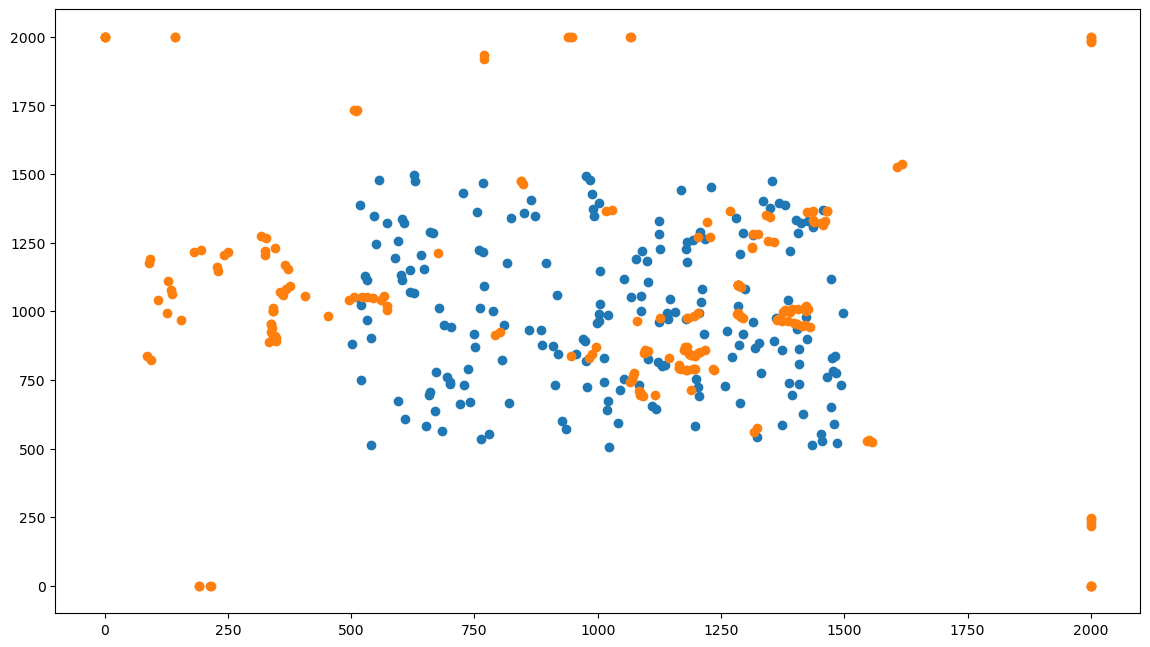

In [324]:
plt.plot(*position_history[0].T, "o")
plt.plot(*position_history[-1].T, "o")

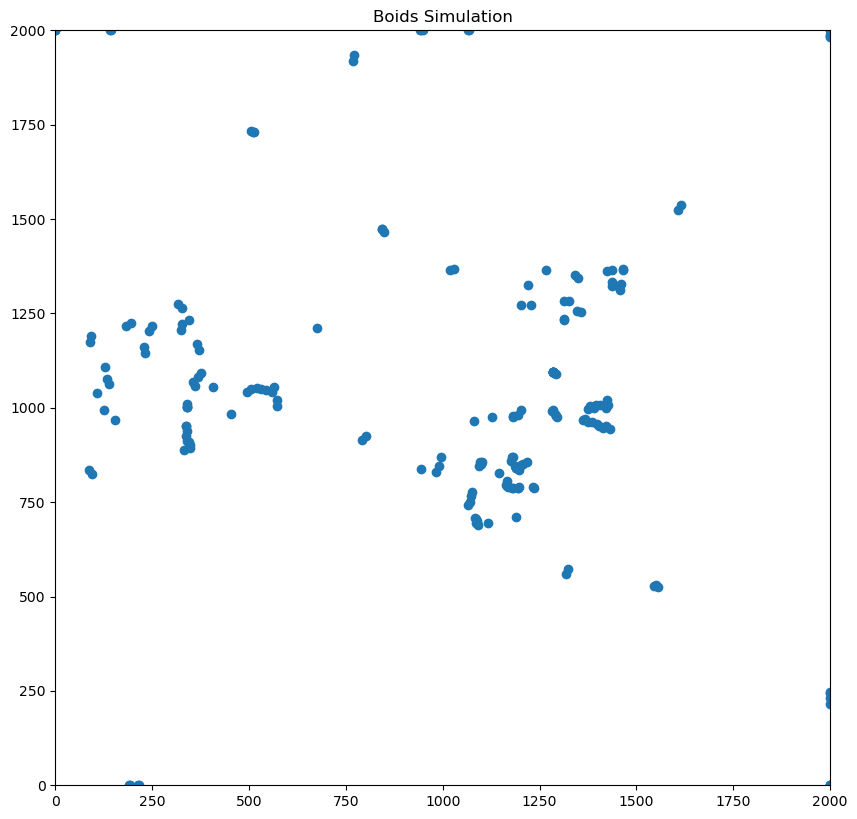

In [325]:
def plot_animation(simulation_data):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    def update(frame):
        ax.clear()
        ax.set_xlim(0, WIDTH)
        ax.set_ylim(0, HEIGHT)
        ax.scatter(simulation_data[frame, :, 0], simulation_data[frame, :, 1])
        ax.set_title('Boids Simulation')

    anim = FuncAnimation(fig, update, frames=len(simulation_data), repeat=False)
    anim.save("boids_simulation.gif", writer="pillow")

plot_animation(position_history)

# Aggregation measure
Entropy can be interpreted as a measure of disorder of a system.
An ordered system, such as an ice cube have a low entropy since the water-molecules are ordered in a regular way (crystal structure).
An unordered system would be the melted ice cube. The order of the water-molecules are less ordered because they are not bounded to each other in a crystal structure. The water pool thus have a higher entropy than the ice cube. \
\
Entropy can be formalized to work on a propability density function $\rho$. A "narrow looking" density function have a lower entropy than a "wide spread". For instance, a Gaussian with standard deviation 1 have lower entropy than a Gaussian with standard deviation 2. 
There are various different entropy formulations, I will use the Shannon entropy as a starting point for the aggregation measure, which is defined as: 
\begin{equation}
    S = -\sum_i \rho_i\log\rho_i.
\end{equation}
However, we want the aggregation measure to be large when the particles are closely gathered which is the opposite behavior of the Shannon entropy. Therefore, I use the negative Shannon entropy as my aggregation measure:
\begin{equation}
    A = -S = \sum_i \rho_i\log\rho_i.
\end{equation}

In [125]:
def compute_entropy(xy, bins=N // 50): # Negative Shannon entropy
    hist, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], bins=bins, density=True)
    hist = hist[hist > 0]  # remove zero entries
    return -np.sum(hist * np.log(hist))  # compute (negative) entropy

In [132]:
time_steps = 50
dt = 2000 / time_steps

def run_simulation(xy, v, r1, r2, r3, rho1, rho2, rho3, rho4, eta):
    for t in range(time_steps):

        distance = get_distances(xy)
        repelling_indices  = (distance != 0)  * (distance < r1)
        alignment_indices  = (distance >= r1) * (distance < r2)
        attracting_indices = (distance >= r2) * (distance < r3)

        theta1_values = theta1(xy)
        theta3_values = theta3(xy)

        # Update velocities
        for i in range(N):
            theta2_value  = theta2(xy, v, i)
            repelling_angles = theta1_values[repelling_indices[i]]
            attracting_angles = theta3_values[attracting_indices[i]]

            # Update angle
            angle = update_angle(repelling_angles, theta2_value, attracting_angles)
            v[i] = [np.cos(angle), np.sin(angle)]

        # Update positions
        xy += v * dt
    return xy


# Assume fixed parameters
rho1 = 0.04
rho2 = 0.01
rho3 = 0.05
rho4 = 0.9
eta = 2 * np.pi / 3

# Discretize the x-y plane into cells
n_cells = 20  # number of cells along each axis
x_values = np.linspace(0.01, 0.99, n_cells)
y_values = np.linspace(0.01, 0.99, n_cells)

# Create an empty array to store entropy values
entropy_values = np.empty((n_cells, n_cells))

# Iterate over the cells
for i, x in tqdm(enumerate(x_values)):
    for j, y in enumerate(y_values):
        # Ensure that x < y
        if x < y:
            # Compute r1, r2 and r3
            r1 = x
            r2 = y
            r3 = 1  # because x, y < 1 and r1/r3 = x, r2/r3 = y

            # Run simulation with these parameters
            position_last_frame = run_simulation(xy, v, r1, r2, r3, rho1, rho2, rho3, rho4, eta)

            # Compute entropy for final positions
            entropy = compute_entropy(position_last_frame)

            # Store result
            entropy_values[j, i] = entropy
        else:
            entropy_values[j, i] = np.nan  # no valid r1, r2, r3


20it [00:23,  1.17s/it]


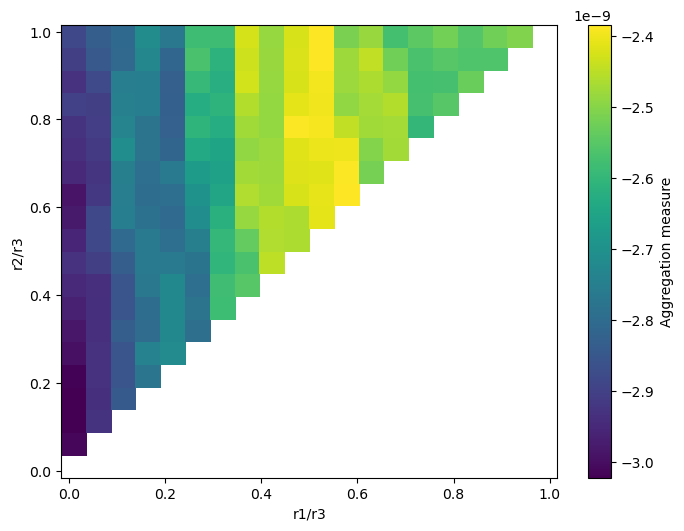

In [133]:
# Create 2D plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(x_values, y_values, -entropy_values, cmap='viridis', shading="auto")
plt.colorbar(label='Aggregation measure')
plt.xlabel('r1/r3')
plt.ylabel('r2/r3')
plt.show()

## Analysis
There seems to be some relatively significant jump in the small regime $r_1/r_3$, this can be seen as phase transitions. A possible explaination is that the perception field of the particles is relatively